In [14]:
import nibabel as nib
import numpy as np
from os.path import join
import math
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests
from nilearn import plotting
from nilearn.image import resample_to_img
from scipy import ndimage

In [3]:
ses = 1
sub = '04'
run = 1

base_path = '/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives'
anat_img = nib.load(f'/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives/sub-pd0{sub}/ses-{ses}/anat/sub-pd0{sub}_ses-{ses}_T1w_brain.nii.gz')

data_name = f'sub-pd0{sub}_ses-{ses}_run-{run}_task-mv_bold_corrected_smoothed_reg.nii.gz'
BOLD_path_org = join(base_path, f'sub-pd0{sub}', f'ses-{ses}', 'func', data_name)
bold_img = nib.load(BOLD_path_org)
bold_data = bold_img.get_fdata()

mask_path = f'/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives/sub-pd0{sub}/ses-{ses}/anat/sub-pd0{sub}_ses-{ses}_T1w_brain_mask.nii.gz'
back_mask = nib.load(mask_path)

mask_path = f'/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives/sub-pd0{sub}/ses-{ses}/anat/sub-pd0{sub}_ses-{ses}_T1w_brain_pve_0.nii.gz'
csf_mask = nib.load(mask_path)

print(anat_img.shape)
print(bold_data.shape)
print(back_mask.shape)
print(csf_mask.shape)

(180, 256, 170)
(180, 256, 170, 850)
(180, 256, 170)
(180, 256, 170)


In [4]:
back_mask_data = back_mask.get_fdata() > 0
csf_mask_data = csf_mask.get_fdata() > 0
mask = np.logical_and(back_mask_data, ~csf_mask_data)
nonzero_mask = np.where(mask)
masked_bold = bold_data[nonzero_mask]

print(f"number of selected voxels after masking: {masked_bold.shape[0]/math.prod(bold_data.shape[:3])*100:.2f}%")
print('bold_data masked shape:', masked_bold.shape)

number of selected voxels after masking: 13.68%
bold_data masked shape: (1071489, 850)


In [5]:
glm_dict = np.load(f'/home/zkavian/thesis_code_git/GLMOutputs-sub{sub}-ses{ses}/TYPED_FITHRF_GLMDENOISE_RR.npy', allow_pickle=True).item()
beta_glm = glm_dict['betasmd']
beta_run1, beta_run2 = beta_glm[:,0,0,:90], beta_glm[:,0,0,90:]
R2_run1, R2_run2 = glm_dict['R2run'][:,:,:,0], glm_dict['R2run'][:,:,:,1]

beta = beta_run1 #beta_glm.shape
R2 = R2_run1

lower_thr, upper_thr = np.nanpercentile(beta, [1, 99])
print(f'low_thr: {lower_thr:.2f}, high_thr: {upper_thr:.2f}') #low_thr: -4.64, high_thr: 4.60
beta_extreme_mask = np.logical_or(beta < lower_thr, beta > upper_thr)
voxels_with_extreme_beta = np.any(beta_extreme_mask, axis=1)

print(f"percentage of voxels with extreme beta values: {np.sum(voxels_with_extreme_beta)/beta.shape[0]*100:.2f}%")


low_thr: -4.64, high_thr: 4.60
percentage of voxels with extreme beta values: 7.43%


In [ ]:
# from plot_func import cfs_brain_mask_plot, mean_beta_outlier_voxels, csf_mask_with_outlier, check_beta_range_and_outliers, check_avg_beta_range

# overlay_view = cfs_brain_mask_plot(nonzero_mask, mask, bold_img, anat_img)
# overlay_view
# mean_beta_outlier_voxels(beta, bold_data, bold_img, anat_img, nonzero_mask, sub, ses, run)
# csf_mask_with_outlier(csf_mask_data, voxels_with_extreme_beta, bold_data, bold_img, anat_img, nonzero_mask, sub, ses, run)
# check_beta_range_and_outliers(beta, bold_data, bold_img, anat_img, nonzero_mask)
# check_avg_beta_range(beta, bold_data, bold_img, anat_img, nonzero_mask)

clean_beta shape: (991899, 90)


/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:627: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return result_to_tuple(hypotest_fun_out(*samples, **kwds), n_out)
/tmp/ipykernel_1028590/514066554.py:7: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  tvals, pvals = ttest_1samp(clean_beta, popmean=0, axis=1, nan_policy='omit')


52.50% of voxels are active at FDR q<0.05


/home/zkavian/thesis_code_git/Optim_fMRI/Optim_fMRI_new/plot_func.py:204: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  stat_img = resample_to_img(stat_img, anat_img, interpolation='linear')
/home/zkavian/thesis_code_git/Optim_fMRI/Optim_fMRI_new/plot_func.py:204: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  stat_img = resample_to_img(stat_img, anat_img, interpolation='linear')
/home/zkavian/thesis_code_git/Optim_fMRI/Optim_fMRI_new/plot_func.py:206: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  view = plotting.view_img(
/home/zkavian/thesis_code_git/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'part

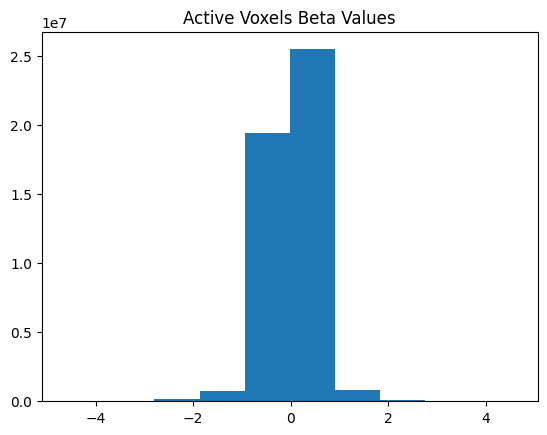

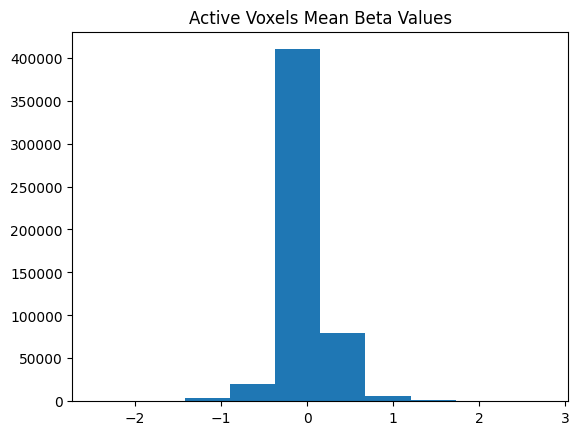

In [20]:
# after removing voxels with extreme beta values
clean_beta = beta[~voxels_with_extreme_beta]
clean_R2 = R2[~voxels_with_extreme_beta]
print('clean_beta shape:', clean_beta.shape)

# one sample t-test against 0
tvals, pvals = ttest_1samp(clean_beta, popmean=0, axis=1, nan_policy='omit')

# FDR correction
tested = np.isfinite(pvals)
alpha=0.05
rej, q, _, _ = multipletests(pvals[tested], alpha=alpha, method='fdr_bh')

n_voxel = clean_beta.shape[0]
qvals  = np.full(n_voxel, np.nan)
reject = np.zeros(n_voxel, dtype=bool)
reject[tested] = rej
qvals[tested]  = q

# rehject non-active voxels
clean_active_beta = clean_beta[reject]
clean_active_R2 = clean_R2[reject]
print(f"{clean_active_beta.shape[0]/clean_beta.shape[0]*100:.2f}% of voxels are active at FDR q<{alpha}")

# # plot hist and beta values of ative voxels
# from plot_func import active_voxel_plot
# active_voxel_plot(clean_active_beta, voxels_with_extreme_beta, reject, bold_img, anat_img, nonzero_mask, sub, ses, run)

In [28]:
# transfer back beta value on the volume
clean_mask = ~np.asarray(voxels_with_extreme_beta, dtype=bool)
clean_indices = np.nonzero(clean_mask)[0]
active_indices = clean_indices[np.asarray(reject, dtype=bool)]

spatial_shape = bold_img.shape[:3]
n_trials = clean_active_beta.shape[1]
beta_volume = np.full(spatial_shape + (n_trials,), np.nan, dtype=np.float32)

coords = tuple(axis[active_indices] for axis in nonzero_mask)
beta_volume[coords[0], coords[1], coords[2], :] = clean_active_beta.astype(np.float32)

In [ ]:



def hampel_filter_image(image, window_size, threshold_factor):
    """
    image: 4D array shaped (rows, cols, depth, time)
    window_size: odd integer, size of the cubic window in (r,c,d)
    threshold_factor: k, where |x - median| > k * (1.4826 * MAD) -> set to NaN
    """
    if window_size % 2 == 0:
        raise ValueError("window_size must be odd")
        
    filtered = image.astype(float).copy()
    footprint = np.ones((window_size,)*3, dtype=bool)

    for t in range(image.shape[3]):
        vol = image[..., t]

        # Local median over the 3D window (NaN-aware via cval=np.nan and np.nanmedian)
        med = ndimage.generic_filter(
            vol, np.nanmedian, footprint=footprint, mode='constant', cval=np.nan
        )

        # Local MAD (median of |x - median|)
        mad = ndimage.generic_filter(
            np.abs(vol - med), np.nanmedian, footprint=footprint, mode='constant', cval=np.nan
        )

        scaled_mad = 1.4826 * mad  # Gaussian-consistent scaling
        valid = ~np.isnan(vol)
        outliers = valid & (np.abs(vol - med) > threshold_factor * scaled_mad)
        filtered[..., t][outliers] = np.nan

    return filtered
